# Image classification using Random Forest

This exercise is meant to perform a pixel-wise classification on a 4 band Planet image using Decision Trees and Random Forest. The image has been acquired over a region in the Flevoland province of the Netherlands.

Version: 1

Last modified: 14 Oct 2019

This code is developed for educational purpose, to be used in Module "Advanced Image Analysis" at ITC.

The code is developed by Anurag Kulshrestha, with documentation help from Mr. John Ray Bergado.

The code is optimized for clarity rather than for computational efficiency.

Do not remove this announcement.

The code is distributed "as is", WITH NO WARRANTY whatsoever!

[Part 1](#part_0) of the exercise describes the procedure for installation of software required for the exercise.

[Part 2](#part_1) imports the required libraries.




The code in this notebook can be run by clicking the cell containing the code block and pressing SHIFT+ENTER.

## Part 0: Installation of software<a id='part_0'></a>

<h4>0.1: Installing Python</h4>

If Python is not yet installed, we suggest you install Anaconda 3. This is a python distribution package with a wide collection of additional packages. Furthermore, it allows for easy installation of Tensorflow and Keras through 'pip'. You can download the Anaconda 3 64-bit installer for Windows [here](https://repo.anaconda.com/archive/Anaconda3-2019.07-Windows-x86_64.exe). Execute the installer and wait for it to finish the installation (this might take a few minutes, perhaps grab a cup of cofee or tea).


<h4>0.2: Creating Anaconda environment</h4>

```
C:> conda create -n rforest python=3.6
```

to create an Anaconda environment where you will install all the necessary Python packages. An environment allows you to install several versions of a package independently (in a self-contained manner avoiding conflicting versions). Followed by a command activating the environment:

```
C:> activate rforest
(rforest)C:>  # Your prompt should change 
```

which you should always do so that you can use the packages you will be installing in this environment.

<h4>0.3: Installing gdal, rasterio and sklearn</h4>

Aside from the other python packages required in installing Tensorflow and Keras (such as numpy, scipy, etc), we need to install the gdal library, matplotlib, h5py, scikit-image, and scikit-learn. To install gdal, issue the command:

```
(rforest)C:> conda install gdal 
```

To install the other miscallaneous packages issue the command:

```
(rforest)C:> conda install rpy2 rasterio matplotlib scikit-image scikit-learn pydot
```

And finally, to view this notebook you need to install jupyter by issuing the command:

```
(rforest)C:> pip install jupyter
```

<h4>0.4: Testing the installation</h4>

If you have installed all the packages, you can test if all the installations were successful by trying to import all these packages. You can do this by:

```
(rforest)C:> python
>>> import gdal, matplotlib, skimage, sklearn, rpy2
```

If the import have not raised any error, the installation should have been successful. You can now then quit the python interactive console by:

```
>>> quit()
```

You should get back to the Anaconda environment and should change to the directory where you placed this notebook by:

```
(rforest)C:> cd ''directory where this notebook is''
(rforest)C:''directory where this notebook is''> jupyter notebook
```

A tab in your default web browser should open listing with graphical interface listing the files in the directory where this notebook is. Click this notebook to run it, a new tab in the browser should open this notebook.

## Part1: Importing the libraries<a id='part_1'></a>

In [3]:
import sys
import numpy as np
import gdal
import ogr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
# import pydot
# from random_forest import *

## Part2: Reading the images<a id='part_2'></a>

In [2]:
#**********************************
# Declare your file directory here
#**********************************
dir='/home/anurag/Documents/Teaching/ImageAnalysis/DecisionTrees/ImageAnalysis_data/'

#**********************************
#Declare the name of image file and training shape file here 
#**********************************
planet_image_name = 'Flevoland_planet.tif'
training_shp = 'Flevoland_Samples.shp'

#**********************************#**********************************
#Lets go our working directory, shall we?
os.chdir(dir)
#**********************************#**********************************

#**********************************#**********************************
#Lets use space technology for something amazing, a.k.a. lets read the image file
#**********************************#**********************************

def read_image(dir, img_name):
    img = gdal.Open(os.path.join(dir,img_name))
    img_arr = img.ReadAsArray()
    img_gt = img.GetGeoTransform()
    img_georef = img.GetProjectionRef()
    return [img_arr, img_gt, img_georef]


img = read_image(dir, planet_image_name)
img_arr=img[0]
img_gt=img[1]
img_georef=img[2]
nR,nG,nB,nNIR = 2,1,0,3 #Do you know the band numbers in the image? Put them here. e.g. Red is the second band in the image.
band_names=['Blue', 'Green', 'Red', 'NIR']

#### Visualizing the read image

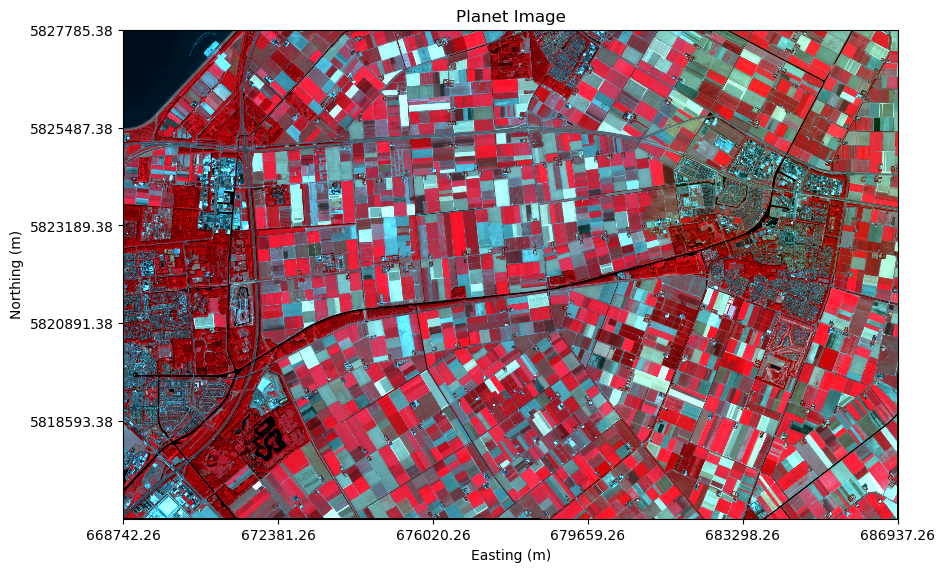

In [5]:
#**********************************#**********************************
#Lets now see what we have read. Looks okay?
#**********************************#**********************************
rgb_bands = (nNIR, nR, nG) # For an FCC image
clip_extremes = True

def pixel_id_to_lat(GT, Y):
    lat=GT[5]*Y + GT[3]
    return lat
    #return round(lat,2)

def pixel_id_to_lon(GT, X):
    lon=GT[1]*X + GT[0]
    return lon
    #return round(lon,2)
    
def coord_to_pixel_id(GT, lat, lon ):
    Y=(lat-GT[3])//GT[5]
    X=(lon-GT[0])//GT[1]
    return (X,Y)

def hist_stretch_all(arr, bits, clip_extremes):
    n=arr.shape
    per=np.percentile(arr,[2.5, 97.5])
    per_max=per[1]
    per_min=per[0]
    min_arr=np.full(n, per_min)
    max_arr=np.full(n, per_max)
    if(clip_extremes==False):
        new_arr=arr
    else:
        new_arr=np.maximum(min_arr, np.minimum(max_arr, arr))
    if(bits==0):
        min_=np.amin(new_arr)
        max_=np.amax(new_arr)
        new_arr=(new_arr-min_)/(max_-min_)
    else:
        new_arr=np.floor((2**bits-1)*(new_arr-per_min)/(per_max-per_min))
    return new_arr

def display(arr, img_gt, cmap, x_label, y_label, title, num_ticks=5, colorbar=True):
    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
    imgplot=plt.imshow(arr, cmap=cmap)
    #plt.set_yticklabels()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.title('('+mat_ele+') '+title)
    plt.title(title)
    lat_pixels=list(range(0,arr.shape[0],arr.shape[0]//num_ticks))
    lon_pixels=list(range(0,arr.shape[1],arr.shape[1]//num_ticks))
    
    plt.xticks(lon_pixels, [str(round(pixel_id_to_lon(img_gt,i),2)) for i in lon_pixels])
    plt.yticks(lat_pixels, [str(round(pixel_id_to_lat(img_gt,i),2)) for i in lat_pixels])
    
    if colorbar:
        plt.colorbar()
        
    #plt.savefig
    plt.show()

def plot_image(img_arr, img_gt, rgb_bands, clip_extremes=False):
    r=hist_stretch_all(img_arr[rgb_bands[0]], 0, clip_extremes)
    b=hist_stretch_all(img_arr[rgb_bands[2]], 0, clip_extremes)
    g=hist_stretch_all(img_arr[rgb_bands[1]], 0, clip_extremes)
    img = np.dstack((r,g,b))
    display(img, img_gt, None, 'Easting (m)', 'Northing (m)', 'Planet Image', num_ticks=5, colorbar=False)
    

    
plot_image(img_arr, img_gt, rgb_bands, clip_extremes=clip_extremes)

#### QUESTION1: 

Switch the parameter ```clip_extremes``` to False and see what happens. PLease explain why?

In [6]:
#**********************************#**********************************
#Now that we have visualized the image, lets make a dataframe of the image
#**********************************#**********************************

def make_data_frame(img_arr, col_names):
    shp=img_arr.shape
    print(shp)
    #return 0
    if len(shp)>2:
        data=img_arr.flatten().reshape(shp[0],shp[1]*shp[2]).T
    else:
        data = img_arr.flatten()
    df=pd.DataFrame(data, columns=col_names)
    df=df.where(df!=0)
    #print(df)
    return df

df=make_data_frame(img_arr, band_names)
df['Easting']=pixel_id_to_lon(img_gt, np.arange(df.shape[0])%img_arr.shape[2])
df['Northing']=pixel_id_to_lat(img_gt, np.repeat(np.arange(img_arr.shape[1]), img_arr.shape[2]))

(4, 3830, 6069)


In [7]:
#**********************************#**********************************
#Let us now read the shapefile and start constructing the training datasets
#**********************************#**********************************
def subset_TR_TS(shapefile):
    
    #Sample polygons from the training set to get a more even distribution of training samples
    #shapefile = shapefile.groupby('Class', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
    print(shapefile['Class'].value_counts())
    
    TR = shapefile.sample(800)
    TS = pd.concat([shapefile, TR, TR]).drop_duplicates(keep=False)
    print(TR['Class'].value_counts())
    print(TS['Class'].value_counts())
    #return 0
    TR.to_file("TR.shp")
    TS.to_file("TS.shp")

def get_overlapping_pixels(img_name, classwise_polygons):
    with rio.open(img_name) as src:
    #classwise_image, out_transform = mask(src, shapefile.geometry,crop=True)
        classwise_images = [mask(src, i.geometry,crop=False)[0][0] for i in classwise_polygons]
        #plt.imshow(classwise_images[3])
        #plt.show()
        training_set_loc = [np.where(image!=0) for image in classwise_images]
        
        df=pd.DataFrame(columns=[*band_names, 'Class'])

        for i,Class in enumerate(classes_legend):
            data=img_arr[:,training_set_loc[i][0], training_set_loc[i][1]].T
            df_class = pd.DataFrame(data, columns=band_names)

            df_class['Class']=np.repeat(str(Class),training_set_loc[i][0].size).T
            df_class=df_class.where(df_class!=0).dropna()

            df=pd.concat([df,df_class])
    return df

shapefile = gpd.read_file(training_shp)

#subset_TR_TS(shapefile)


#Load the training and testing sets
TR_shp = gpd.read_file("TR.shp")
TS_shp = gpd.read_file("TS.shp")

#Print unique classes in the training set
classes =  shapefile["Class"].unique()
classes_legend=np.arange(1,classes.size+1)
print('Class legend')
print(classes)
print(classes_legend)

classwise_polygons_TR = [TR_shp.where(TR_shp["Class"]==Class, inplace=False).dropna() for Class in classes]
#print([classwise_polygons[i]['Class'].value_counts() for i in range(len(classes))])

classwise_polygons_TS = [TS_shp.where(TS_shp["Class"]==Class, inplace=False).dropna() for Class in classes]
#print([classwise_polygons[i]['Class'].value_counts() for i in range(len(classes))])

TR_df = get_overlapping_pixels(planet_image_name, classwise_polygons_TR)
TS_df = get_overlapping_pixels(planet_image_name, classwise_polygons_TS)




# This is a large training set. Shall we sample a subset of it?
num_samples_TR=5000
num_samples_TS=2500

TR_df=TR_df.sample(num_samples_TR)
TS_df=TS_df.sample(num_samples_TS)
print('Training data shape:', TR_df.shape)
print('Test data shape:', TS_df.shape)
#print(TR)

#Lets see the class count
print('Training data classwise counts \n', TR_df['Class'].value_counts())
print('Training data classwise counts \n', TS_df['Class'].value_counts())
#STOP-2
#sys.exit()

Class legend
['Arable' 'Grassland' 'BuiltUp' 'Forest' 'Water']
[1 2 3 4 5]
Training data shape: (5000, 5)
Test data shape: (2500, 5)
Training data classwise counts 
 1    4298
2     454
3     178
4      39
5      31
Name: Class, dtype: int64
Training data classwise counts 
 1    2151
2     222
3      69
5      45
4      13
Name: Class, dtype: int64


#### QUESTION 2: 
Looks like the training dataset is prepared. Can you visualize the class-wise distribution of the training datasets?

#### QUESTION 3: 
The traning samples seems to be unblanced too heavily in the favour of the class: 'Arable'. Can you rectify it? What is it's effect on the classification results?

In [8]:
# Lets now split the TR into training and test set

stratify=None
#stratify=classes
train_x, test_x, train_y, test_y = TR_df.iloc[:,:-1],TS_df.iloc[:,:-1],TR_df.iloc[:,-1],TS_df.iloc[:,-1]

# Train and Test dataset size details
print ("Train_x Shape :: ", train_x.shape)
print ("Train_y Shape :: ", train_y.shape)
print ("Test_x Shape :: ", test_x.shape)
print ("Test_y Shape :: ", test_y.shape)

Train_x Shape ::  (5000, 4)
Train_y Shape ::  (5000,)
Test_x Shape ::  (2500, 4)
Test_y Shape ::  (2500,)


## Decision Trees

In [9]:
# Define the function for the decision tree classifier
def decision_tree_classifier(features, target, options=None):
    """
    To train the decision_tree_classifier with features and target data
    :param features:
    :param target:
    :return: trained decision_tree_classifier
    """
    if options:
        clf = tree.DecisionTreeClassifier(**options)
        #print('options lag gaye')
    else:
        clf = tree.DecisionTreeClassifier()
    clf.fit(features, target)
    return clf

Let us now define the hyper-paramerter for the Deciosion Tree Classifier. Define the parameters here.
Please find the details for the classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [10]:
d_tree_options=dict(
    criterion='gini', 
    splitter='best', 
    max_depth=10, #This has been kept to a low number so as to visualize the decision tree. 
    #Please experiment with this value and assess the classification accuracy for various values of this parameter.
    min_samples_split=10, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight=None, 
    presort=False
    )

#### Training the classifier

In [11]:
trained_model = decision_tree_classifier(train_x, train_y, d_tree_options)

print ("Trained model :: ", trained_model)

Trained model ::  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


#### Visualization of the trained decision tree model

In [12]:
out_file_name = 'tree_DT_jupyter_2'

dot_data = tree.export_graphviz(trained_model, out_file=out_file_name+'.dot', feature_names=band_names, class_names=classes, filled=True, rounded=True, special_characters=True)
(graph, ) = pydot.graph_from_dot_file(out_file_name+'.dot')
## Write graph to a png file
graph.write_png(out_file_name+'.png')

#### Visualization of the division of feature space

IndexError: positional indexers are out-of-bounds

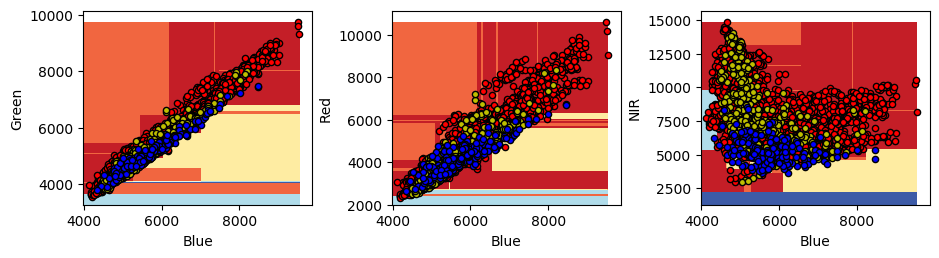

In [13]:
# Parameters
n_classes = classes.size
plot_colors = "ryb"
plot_step = 5
figure(num=None, figsize=(10, 10), dpi=100)
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [0, 4],
                                [1, 2], [1, 3], [1, 4], 
                                [2, 3], [2,4],
                               [3,4]]):
    # We only take the two corresponding features
    X = train_x.iloc[:, pair]
    y = train_y

    # Train
    clf = tree.DecisionTreeClassifier(**d_tree_options).fit(X, y)
    #break

    # Plot the decision boundary
    plt.subplot(4, 3, pairidx + 1)

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(band_names[pair[0]])
    plt.ylabel(band_names[pair[1]])

    # Plot the training points
    for i, color in zip(classes_legend, plot_colors):
        #print(y.columns)
        #print(y.values[1])
        #print(str(i)==y[1])
        idx = y.index[y == str(i)].tolist()
        #print(idx)
        #break
        #print(X.loc[idx, 'Blue'])
        plt.scatter(X.loc[idx, band_names[pair[0]]], X.loc[idx, band_names[pair[1]]], 
                    c=color, label=classes[i],cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

#### Testing the accuracy of the classification

In [14]:
predictions = trained_model.predict(test_x)

#for i in range(0, 5):
    #print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i]))

# Train and Test Accuracy
print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))

print (" Confusion matrix \n", confusion_matrix(test_y, predictions))

Train Accuracy ::  0.9054
Test Accuracy  ::  0.8548
 Confusion matrix 
 [[2052   57   34    8    0]
 [ 211    7    1    3    0]
 [  42    3   24    0    0]
 [   3    1    0    9    0]
 [   0    0    0    0   45]]


## Bagging of classifiers

Repeat the above process using A 'BAG' of decision trees

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=4)
bag_clf.fit(train_x, train_y)



BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

#### Question
Predict using the bad of classifiers and compare the classification accuracies

# Day 2

In [ ]:
def random_forest_classifier(features, target, options):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    if options:
        clf = RandomForestClassifier(**options)
        #print('options lag gaye')
    else:
        clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

In [ ]:
#Let us now define the randomForestClassifier. Define the parameters here.
rand_forest_options=dict(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2, #changed from 2
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=True,
    n_jobs=8,
    random_state=None, verbose=0, warm_start=False, class_weight=None
    )

In [ ]:
trained_model = random_forest_classifier(train_x, train_y, options=rand_forest_options)

#trained_model = decision_tree_classifier(train_x, train_y, options=dict(min_samples_split=10,max_depth=None))

In [ ]:
predictions = trained_model.predict(test_x)

#for i in range(0, 5):
    #print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i]))

# Train and Test Accuracy
print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))

print (" Confusion matrix \n", confusion_matrix(test_y, predictions))


### Question
Are you happy with this acccuracy? Can you increase it? How does this accuracy score compare to the oob error?

## Image output
Are you happy with the classification? Good? Lets try to classify the entire image then

In [ ]:
#Are you happy with the classification? Good? Lets try to classify the entire image then
del(TR_shp,TS_shp,TR_df,TS_df,train_x, test_x, train_y, test_y)

In [16]:
# Create our imputer to replace missing values with the mean e.g.
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(df.iloc[:,:4])
df_imp = imp.transform(df.iloc[:,:4])
print(df_imp.shape)

(23244270, 4)


In [17]:
predictions_image = trained_model.predict(df_imp)

print(df.shape)
print(predictions_image.shape)

(23244270, 6)
(23244270,)


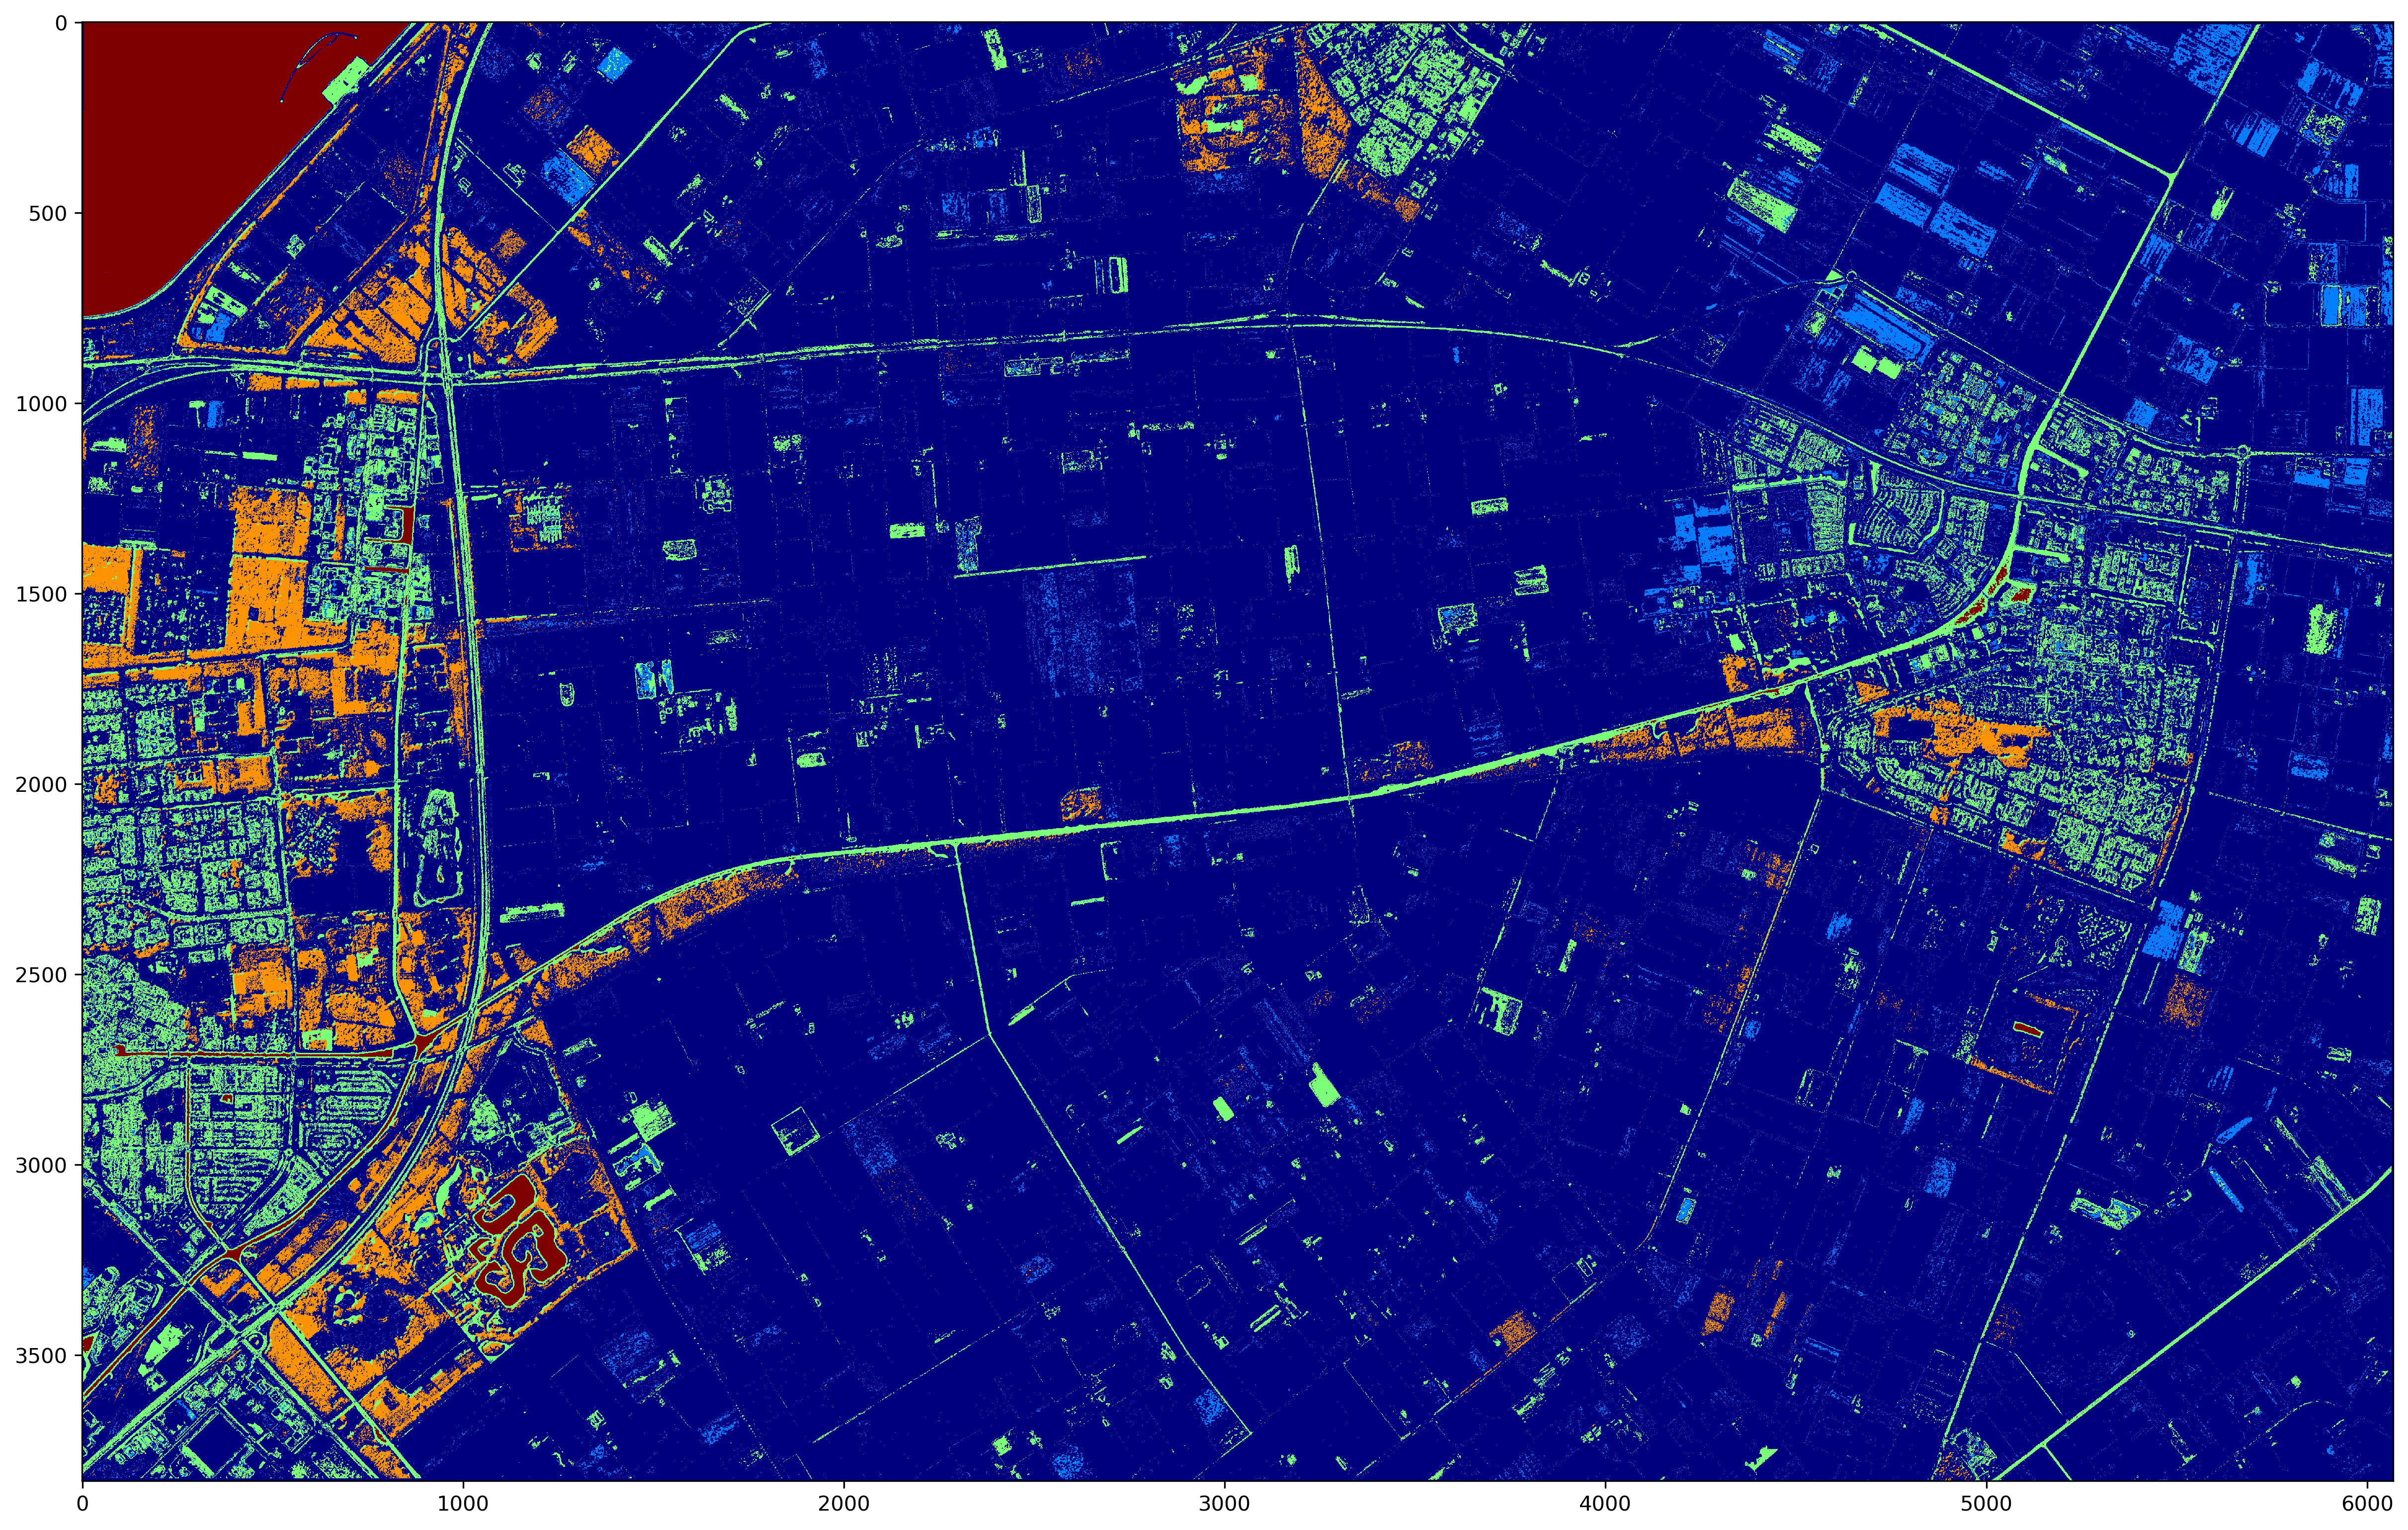

In [18]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=300, facecolor='w', edgecolor='k')
plt.imshow(predictions_image.astype(int).reshape(*(img_arr.shape[1:])), cmap='jet')
#plt.colorbar()
plt.show()

## oob error

In [ ]:
def get_oobscore(X,y):
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE,n_jobs=4)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE,n_jobs=4)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE,n_jobs=4))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 30
    max_estimators = 175

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

from collections import OrderedDict  
RANDOM_STATE = 123
get_oobscore(train_x, train_y)

### Feature importance

In [ ]:
f_imp = trained_model.feature_importances_

plt.imshow(np.array([f_imp]), cmap='jet')
plt.colorbar()
plt.show()